In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:31]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[30:60]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


In [12]:
Dataset = 'MAP Dataset'

In [13]:

f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 22.140482425689697 [s] ... size 2054.8256 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')
'''

In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

In [ ]:
'''
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

In [ ]:
'''
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [19]:

start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [21:33<00:00, 43.13s/it]


In [20]:

for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 56337.19it/s]


In [ ]:
'''
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [29]:

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [30]:

start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [04:01<00:00,  8.03s/it]


In [31]:

for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 244565.83it/s]


In [ ]:
'''
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

In [ ]:
'''
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [ ]:
'''
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [36]:

start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [17:13<00:00, 34.45s/it]


In [37]:

for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 24404.41it/s]


In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [42]:

start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


In [43]:

for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 178607.69it/s]


In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

In [ ]:
'''
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [21]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [22]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [23]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [24]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:

'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [25]:

H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 88341
Number of matches After Lowe's Ratio 27244


  3%|▎         | 1/31 [00:12<06:11, 12.40s/it]

Number of Robust matches 24061




  6%|▋         | 2/31 [00:24<06:00, 12.44s/it]


Number of matches 94166
Number of matches After Lowe's Ratio 28106
Number of Robust matches 24233



Number of matches 95992
Number of matches After Lowe's Ratio 31765


 10%|▉         | 3/31 [00:37<05:51, 12.56s/it]

Number of Robust matches 30215



Number of matches 101174
Number of matches After Lowe's Ratio 33334


 13%|█▎        | 4/31 [00:52<05:54, 13.14s/it]

Number of Robust matches 31949



Number of matches 105076
Number of matches After Lowe's Ratio 35950


 16%|█▌        | 5/31 [01:07<05:54, 13.62s/it]

Number of Robust matches 34051



Number of matches 108299
Number of matches After Lowe's Ratio 36707


 19%|█▉        | 6/31 [01:22<05:53, 14.16s/it]

Number of Robust matches 31459



Number of matches 112278
Number of matches After Lowe's Ratio 39250


 23%|██▎       | 7/31 [01:37<05:48, 14.53s/it]

Number of Robust matches 34940



Number of matches 114384
Number of matches After Lowe's Ratio 38236


 26%|██▌       | 8/31 [01:54<05:46, 15.05s/it]

Number of Robust matches 33689



Number of matches 113737
Number of matches After Lowe's Ratio 37076


 29%|██▉       | 9/31 [02:10<05:37, 15.36s/it]

Number of Robust matches 32776



Number of matches 118930
Number of matches After Lowe's Ratio 37930


 32%|███▏      | 10/31 [02:27<05:33, 15.87s/it]

Number of Robust matches 31762




 35%|███▌      | 11/31 [02:43<05:19, 15.96s/it]


Number of matches 118140
Number of matches After Lowe's Ratio 3063
Number of Robust matches 2106



Number of matches 115591
Number of matches After Lowe's Ratio 61026


 39%|███▊      | 12/31 [02:59<05:06, 16.15s/it]

Number of Robust matches 57772



Number of matches 112586
Number of matches After Lowe's Ratio 38726


 42%|████▏     | 13/31 [03:16<04:50, 16.14s/it]

Number of Robust matches 33571



Number of matches 109221
Number of matches After Lowe's Ratio 37890


 45%|████▌     | 14/31 [03:31<04:31, 15.96s/it]

Number of Robust matches 33717



Number of matches 106656
Number of matches After Lowe's Ratio 35665


 48%|████▊     | 15/31 [03:46<04:10, 15.66s/it]

Number of Robust matches 32178



Number of matches 104945
Number of matches After Lowe's Ratio 32957


 52%|█████▏    | 16/31 [04:00<03:49, 15.27s/it]

Number of Robust matches 28235



Number of matches 106561
Number of matches After Lowe's Ratio 34401


 55%|█████▍    | 17/31 [04:15<03:30, 15.02s/it]

Number of Robust matches 31518



Number of matches 107398
Number of matches After Lowe's Ratio 33885


 58%|█████▊    | 18/31 [04:30<03:15, 15.07s/it]

Number of Robust matches 27051



Number of matches 103671
Number of matches After Lowe's Ratio 29522
Number of Robust matches 

 61%|██████▏   | 19/31 [04:45<02:59, 14.95s/it]

27814



Number of matches 98246
Number of matches After Lowe's Ratio 27926


 65%|██████▍   | 20/31 [04:59<02:40, 14.63s/it]

Number of Robust matches 23759




 68%|██████▊   | 21/31 [05:12<02:23, 14.37s/it]


Number of matches 100667
Number of matches After Lowe's Ratio 25122
Number of Robust matches 21230




 71%|███████   | 22/31 [05:26<02:05, 13.99s/it]


Number of matches 91353
Number of matches After Lowe's Ratio 2616
Number of Robust matches 1213



Number of matches 91080
Number of matches After Lowe's Ratio 55253


 74%|███████▍  | 23/31 [05:38<01:48, 13.52s/it]

Number of Robust matches 54652



Number of matches 88279
Number of matches After Lowe's Ratio 31737


 77%|███████▋  | 24/31 [05:50<01:31, 13.13s/it]

Number of Robust matches 28531




 81%|████████  | 25/31 [06:02<01:16, 12.79s/it]


Number of matches 93308
Number of matches After Lowe's Ratio 29577
Number of Robust matches 26721



Number of matches 97662
Number of matches After Lowe's Ratio 31628


 84%|████████▍ | 26/31 [06:15<01:04, 12.85s/it]

Number of Robust matches 29514



Number of matches 104046
Number of matches After Lowe's Ratio 32052


 87%|████████▋ | 27/31 [06:29<00:52, 13.22s/it]

Number of Robust matches 30865



Number of matches 108409
Number of matches After Lowe's Ratio 32605


 90%|█████████ | 28/31 [06:48<00:44, 14.90s/it]

Number of Robust matches 31526




 94%|█████████▎| 29/31 [07:06<00:31, 15.72s/it]


Number of matches 96764
Number of matches After Lowe's Ratio 5078
Number of Robust matches 3695



Number of matches 92348
Number of matches After Lowe's Ratio 42625


  0%|          | 0/30 [00:00<?, ?it/s]

Number of Robust matches 40052




  3%|▎         | 1/30 [00:11<05:46, 11.96s/it]


Number of matches 88001
Number of matches After Lowe's Ratio 27878
Number of Robust matches 25690




  7%|▋         | 2/30 [00:23<05:33, 11.90s/it]


Number of matches 85914
Number of matches After Lowe's Ratio 26635
Number of Robust matches 20701




 10%|█         | 3/30 [00:35<05:20, 11.87s/it]


Number of matches 85522
Number of matches After Lowe's Ratio 25022
Number of Robust matches 23259



Number of matches 87198
Number of matches After Lowe's Ratio 29261


 13%|█▎        | 4/30 [00:47<05:09, 11.91s/it]

Number of Robust matches 24635



Number of matches 87090
Number of matches After Lowe's Ratio 53003


 17%|█▋        | 5/30 [00:59<04:59, 11.98s/it]

Number of Robust matches 52478




 20%|██        | 6/30 [01:11<04:43, 11.80s/it]


Number of matches 82343
Number of matches After Lowe's Ratio 1967
Number of Robust matches 1380




 23%|██▎       | 7/30 [01:22<04:27, 11.63s/it]


Number of matches 83074
Number of matches After Lowe's Ratio 22347
Number of Robust matches 21069




 27%|██▋       | 8/30 [01:34<04:16, 11.66s/it]


Number of matches 89394
Number of matches After Lowe's Ratio 24216
Number of Robust matches 22773



Number of matches 89318
Number of matches After Lowe's Ratio 26232


 30%|███       | 9/30 [01:46<04:09, 11.87s/it]

Number of Robust matches 21488




 33%|███▎      | 10/30 [01:58<04:01, 12.07s/it]


Number of matches 88407
Number of matches After Lowe's Ratio 26486
Number of Robust matches 23724




 37%|███▋      | 11/30 [02:10<03:47, 11.99s/it]


Number of matches 86118
Number of matches After Lowe's Ratio 25420
Number of Robust matches 21582




 40%|████      | 12/30 [02:22<03:35, 11.98s/it]


Number of matches 88520
Number of matches After Lowe's Ratio 25452
Number of Robust matches 24339



Number of matches 90080
Number of matches After Lowe's Ratio 26298


 43%|████▎     | 13/30 [02:34<03:24, 12.02s/it]

Number of Robust matches 19088




 47%|████▋     | 14/30 [02:47<03:15, 12.21s/it]


Number of matches 94037
Number of matches After Lowe's Ratio 26405
Number of Robust matches 25206




 50%|█████     | 15/30 [03:00<03:07, 12.51s/it]


Number of matches 101942
Number of matches After Lowe's Ratio 29602
Number of Robust matches 25695



Number of matches 105213
Number of matches After Lowe's Ratio 32890


 53%|█████▎    | 16/30 [03:18<03:16, 14.07s/it]

Number of Robust matches 28909



Number of matches 109462
Number of matches After Lowe's Ratio 35095


 57%|█████▋    | 17/30 [03:36<03:18, 15.29s/it]

Number of Robust matches 33433



Number of matches 112453
Number of matches After Lowe's Ratio 35803


 60%|██████    | 18/30 [03:55<03:16, 16.38s/it]

Number of Robust matches 34406



Number of matches 113652
Number of matches After Lowe's Ratio 37778


 63%|██████▎   | 19/30 [04:14<03:08, 17.16s/it]

Number of Robust matches 34672



Number of matches 116176
Number of matches After Lowe's Ratio 38467


 67%|██████▋   | 20/30 [04:33<02:58, 17.85s/it]

Number of Robust matches 31737



Number of matches 120113
Number of matches After Lowe's Ratio 38647


 70%|███████   | 21/30 [04:53<02:45, 18.37s/it]

Number of Robust matches 37111



Number of matches 125089
Number of matches After Lowe's Ratio 40527


 73%|███████▎  | 22/30 [05:14<02:32, 19.03s/it]

Number of Robust matches 37338



Number of matches 131100
Number of matches After Lowe's Ratio 40485


 77%|███████▋  | 23/30 [05:35<02:18, 19.72s/it]

Number of Robust matches 35019



Number of matches 136453
Number of matches After Lowe's Ratio 38333


 80%|████████  | 24/30 [05:57<02:03, 20.54s/it]

Number of Robust matches 36181



Number of matches 143354
Number of matches After Lowe's Ratio 59206


 83%|████████▎ | 25/30 [06:21<01:47, 21.48s/it]

Number of Robust matches 43158




 87%|████████▋ | 26/30 [06:44<01:28, 22.01s/it]


Number of matches 134598
Number of matches After Lowe's Ratio 4281
Number of Robust matches 3180



Number of matches 141379
Number of matches After Lowe's Ratio 29275


 90%|█████████ | 27/30 [07:07<01:07, 22.35s/it]

Number of Robust matches 22900



Number of matches 138973
Number of matches After Lowe's Ratio 30674


 93%|█████████▎| 28/30 [07:31<00:45, 22.72s/it]

Number of Robust matches 24884



Number of matches 137507
Number of matches After Lowe's Ratio 33260


 97%|█████████▋| 29/30 [07:54<00:22, 22.79s/it]

Number of Robust matches 26894




In [26]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.018250226974487305 [s] ... size 0.004208 MB


In [27]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.01159048080444336 [s] ... size 0.004136 MB


In [28]:

del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [32]:

H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  3%|▎         | 1/31 [00:13<06:36, 13.21s/it]


Number of matches 98349
Number of matches After Lowe's Ratio 14899
Number of Robust matches 12979




  6%|▋         | 2/31 [00:26<06:27, 13.35s/it]


Number of matches 103567
Number of matches After Lowe's Ratio 15644
Number of Robust matches 14442




 10%|▉         | 3/31 [00:40<06:19, 13.54s/it]


Number of matches 105630
Number of matches After Lowe's Ratio 17832
Number of Robust matches 15907



Number of matches 109571
Number of matches After Lowe's Ratio 18447


 13%|█▎        | 4/31 [00:55<06:13, 13.84s/it]

Number of Robust matches 17612



Number of matches 114474
Number of matches After Lowe's Ratio 19944


 16%|█▌        | 5/31 [01:10<06:12, 14.33s/it]

Number of Robust matches 18803



Number of matches 117532
Number of matches After Lowe's Ratio 19789


 19%|█▉        | 6/31 [01:29<06:26, 15.48s/it]

Number of Robust matches 19354




 23%|██▎       | 7/31 [01:44<06:12, 15.53s/it]


Number of matches 121048
Number of matches After Lowe's Ratio 21608
Number of Robust matches 19643



Number of matches 124275
Number of matches After Lowe's Ratio 20111


 26%|██▌       | 8/31 [02:00<05:59, 15.65s/it]

Number of Robust matches 15655




 29%|██▉       | 9/31 [02:16<05:45, 15.68s/it]


Number of matches 123507
Number of matches After Lowe's Ratio 19236
Number of Robust matches 17844




 32%|███▏      | 10/31 [02:32<05:32, 15.83s/it]


Number of matches 130314
Number of matches After Lowe's Ratio 19100
Number of Robust matches 17519




 35%|███▌      | 11/31 [02:48<05:18, 15.93s/it]


Number of matches 127900
Number of matches After Lowe's Ratio 1004
Number of Robust matches 564



Number of matches 124225
Number of matches After Lowe's Ratio 39797


 39%|███▊      | 12/31 [03:05<05:06, 16.11s/it]

Number of Robust matches 38125




 42%|████▏     | 13/31 [03:21<04:48, 16.02s/it]


Number of matches 120872
Number of matches After Lowe's Ratio 20199
Number of Robust matches 19537



Number of matches 117502
Number of matches After Lowe's Ratio 19644


 45%|████▌     | 14/31 [03:36<04:29, 15.88s/it]

Number of Robust matches 18073




 48%|████▊     | 15/31 [03:51<04:09, 15.59s/it]


Number of matches 115028
Number of matches After Lowe's Ratio 18792
Number of Robust matches 18242



Number of matches 114348
Number of matches After Lowe's Ratio 17614


 52%|█████▏    | 16/31 [04:06<03:51, 15.41s/it]

Number of Robust matches 16760




 55%|█████▍    | 17/31 [04:21<03:32, 15.21s/it]


Number of matches 115673
Number of matches After Lowe's Ratio 17844
Number of Robust matches 17526



Number of matches 116560
Number of matches After Lowe's Ratio 16839


 58%|█████▊    | 18/31 [04:36<03:17, 15.21s/it]

Number of Robust matches 16243




 61%|██████▏   | 19/31 [04:51<03:00, 15.08s/it]


Number of matches 113196
Number of matches After Lowe's Ratio 14441
Number of Robust matches 13965




 65%|██████▍   | 20/31 [05:05<02:43, 14.90s/it]


Number of matches 109462
Number of matches After Lowe's Ratio 13867
Number of Robust matches 12900




 68%|██████▊   | 21/31 [05:20<02:28, 14.81s/it]


Number of matches 113092
Number of matches After Lowe's Ratio 12337
Number of Robust matches 11513




 71%|███████   | 22/31 [05:34<02:11, 14.63s/it]


Number of matches 105388
Number of matches After Lowe's Ratio 1153
Number of Robust matches 508



Number of matches 104930
Number of matches After Lowe's Ratio 40234


 74%|███████▍  | 23/31 [05:48<01:55, 14.46s/it]

Number of Robust matches 39469




 77%|███████▋  | 24/31 [06:02<01:39, 14.19s/it]


Number of matches 100201
Number of matches After Lowe's Ratio 18017
Number of Robust matches 16936




 81%|████████  | 25/31 [06:15<01:24, 14.03s/it]


Number of matches 103885
Number of matches After Lowe's Ratio 15738
Number of Robust matches 15205




 84%|████████▍ | 26/31 [06:30<01:10, 14.09s/it]


Number of matches 106428
Number of matches After Lowe's Ratio 16274
Number of Robust matches 15455




 87%|████████▋ | 27/31 [06:44<00:56, 14.17s/it]


Number of matches 111359
Number of matches After Lowe's Ratio 16186
Number of Robust matches 15457



Number of matches 116641
Number of matches After Lowe's Ratio 15952


 90%|█████████ | 28/31 [06:59<00:43, 14.42s/it]

Number of Robust matches 13914




 94%|█████████▎| 29/31 [07:13<00:28, 14.40s/it]


Number of matches 105682
Number of matches After Lowe's Ratio 2128
Number of Robust matches 1696




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 102052
Number of matches After Lowe's Ratio 25679
Number of Robust matches 25464




  3%|▎         | 1/30 [00:13<06:25, 13.28s/it]


Number of matches 98753
Number of matches After Lowe's Ratio 15185
Number of Robust matches 13027



Number of matches 95710
Number of matches After Lowe's Ratio 14118


  7%|▋         | 2/30 [00:26<06:13, 13.34s/it]

Number of Robust matches 12644




 10%|█         | 3/30 [00:39<05:57, 13.24s/it]


Number of matches 95017
Number of matches After Lowe's Ratio 13449
Number of Robust matches 12971




 13%|█▎        | 4/30 [00:52<05:42, 13.18s/it]


Number of matches 98100
Number of matches After Lowe's Ratio 16343
Number of Robust matches 14965



Number of matches 98154
Number of matches After Lowe's Ratio 39496


 17%|█▋        | 5/30 [01:06<05:31, 13.26s/it]

Number of Robust matches 39294




 20%|██        | 6/30 [01:19<05:15, 13.14s/it]


Number of matches 92636
Number of matches After Lowe's Ratio 839
Number of Robust matches 503




 23%|██▎       | 7/30 [01:31<04:55, 12.85s/it]


Number of matches 92158
Number of matches After Lowe's Ratio 11269
Number of Robust matches 10794




 27%|██▋       | 8/30 [01:44<04:44, 12.93s/it]


Number of matches 97908
Number of matches After Lowe's Ratio 12555
Number of Robust matches 11865




 30%|███       | 9/30 [01:57<04:33, 13.03s/it]


Number of matches 97510
Number of matches After Lowe's Ratio 14005
Number of Robust matches 13684




 33%|███▎      | 10/30 [02:11<04:22, 13.13s/it]


Number of matches 97047
Number of matches After Lowe's Ratio 14094
Number of Robust matches 13100




 37%|███▋      | 11/30 [02:24<04:08, 13.10s/it]


Number of matches 95300
Number of matches After Lowe's Ratio 13523
Number of Robust matches 11798




 40%|████      | 12/30 [02:37<03:56, 13.12s/it]


Number of matches 97313
Number of matches After Lowe's Ratio 13366
Number of Robust matches 11125



Number of matches 98742
Number of matches After Lowe's Ratio 13781


 43%|████▎     | 13/30 [02:50<03:45, 13.24s/it]

Number of Robust matches 12767




 47%|████▋     | 14/30 [03:03<03:31, 13.24s/it]


Number of matches 102654
Number of matches After Lowe's Ratio 14074
Number of Robust matches 13025




 50%|█████     | 15/30 [03:17<03:21, 13.40s/it]


Number of matches 110193
Number of matches After Lowe's Ratio 15810
Number of Robust matches 15202




 53%|█████▎    | 16/30 [03:32<03:12, 13.78s/it]


Number of matches 114384
Number of matches After Lowe's Ratio 17996
Number of Robust matches 16731




 57%|█████▋    | 17/30 [03:47<03:03, 14.11s/it]


Number of matches 118732
Number of matches After Lowe's Ratio 18954
Number of Robust matches 18501




 60%|██████    | 18/30 [04:04<03:01, 15.15s/it]


Number of matches 121970
Number of matches After Lowe's Ratio 19430
Number of Robust matches 18708




 63%|██████▎   | 19/30 [04:20<02:49, 15.38s/it]


Number of matches 122811
Number of matches After Lowe's Ratio 20707
Number of Robust matches 18466




 67%|██████▋   | 20/30 [04:36<02:35, 15.58s/it]


Number of matches 124988
Number of matches After Lowe's Ratio 20813
Number of Robust matches 19647




 70%|███████   | 21/30 [04:52<02:21, 15.75s/it]


Number of matches 127270
Number of matches After Lowe's Ratio 20809
Number of Robust matches 19581




 73%|███████▎  | 22/30 [05:09<02:08, 16.02s/it]


Number of matches 131363
Number of matches After Lowe's Ratio 20962
Number of Robust matches 19024



Number of matches 136707
Number of matches After Lowe's Ratio 21178


 77%|███████▋  | 23/30 [05:27<01:55, 16.54s/it]

Number of Robust matches 19105




 80%|████████  | 24/30 [05:45<01:42, 17.01s/it]


Number of matches 140397
Number of matches After Lowe's Ratio 20187
Number of Robust matches 17677



Number of matches 148102
Number of matches After Lowe's Ratio 35418


 83%|████████▎ | 25/30 [06:04<01:28, 17.76s/it]

Number of Robust matches 33129




 87%|████████▋ | 26/30 [06:23<01:12, 18.09s/it]


Number of matches 134759
Number of matches After Lowe's Ratio 1576
Number of Robust matches 969




 90%|█████████ | 27/30 [06:41<00:54, 18.05s/it]


Number of matches 140728
Number of matches After Lowe's Ratio 13720
Number of Robust matches 11615




 93%|█████████▎| 28/30 [07:00<00:36, 18.28s/it]


Number of matches 140254
Number of matches After Lowe's Ratio 14494
Number of Robust matches 12749



Number of matches 139658
Number of matches After Lowe's Ratio 15676


 97%|█████████▋| 29/30 [07:19<00:18, 18.44s/it]

Number of Robust matches 13810




In [33]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007755756378173828 [s] ... size 0.004208 MB


In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006611824035644531 [s] ... size 0.004136 MB


In [35]:

del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [ ]:
'''
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [44]:

H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

 10%|▉         | 3/31 [00:00<00:03,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 128



Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 127




 13%|█▎        | 4/31 [00:00<00:02,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 227
Number of Robust matches 153



Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 177




 23%|██▎       | 7/31 [00:00<00:02,  9.32it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 153



Number of matches 1000
Number of matches After Lowe's Ratio 287
Number of Robust matches 210




 29%|██▉       | 9/31 [00:00<00:02,  9.33it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 226



Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 214




 32%|███▏      | 10/31 [00:01<00:02,  9.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 224
Number of Robust matches 185



Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 5


Number of matches After Lowe's Ratio New 33


 39%|███▊      | 12/31 [00:01<00:02,  7.38it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 377
Number of Robust matches 347




 45%|████▌     | 14/31 [00:01<00:02,  8.17it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 281
Number of Robust matches 219



Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 240




 48%|████▊     | 15/31 [00:01<00:01,  8.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 275
Number of Robust matches 225



Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 181



Number of matches 1000
Number of matches After Lowe's Ratio 268


 58%|█████▊    | 18/31 [00:02<00:01,  9.02it/s]

Number of Robust matches 204



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 161




 65%|██████▍   | 20/31 [00:02<00:01,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 96



Number of matches 1000
Number of matches After Lowe's Ratio 220
Number of Robust matches 143




 68%|██████▊   | 21/31 [00:02<00:01,  8.83it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 158
Number of Robust matches 104



Number of matches 1000
Number of matches After Lowe's Ratio 29
Number of Robust matches 5


Number of matches After Lowe's Ratio New 29


 74%|███████▍  | 23/31 [00:02<00:01,  7.38it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 541
Number of Robust matches 534




 81%|████████  | 25/31 [00:02<00:00,  8.09it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 183



Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 167




 87%|████████▋ | 27/31 [00:03<00:00,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 163



Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 229




 90%|█████████ | 28/31 [00:03<00:00,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 175



Number of matches 1000
Number of matches After Lowe's Ratio 34
Number of Robust matches 5


Number of matches After Lowe's Ratio New 34


  0%|          | 0/30 [00:00<?, ?it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 268




  7%|▋         | 2/30 [00:00<00:02,  9.76it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 160




 13%|█▎        | 4/30 [00:00<00:02,  9.08it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 231
Number of Robust matches 146



Number of matches 1000
Number of matches After Lowe's Ratio 185
Number of Robust matches 109




 17%|█▋        | 5/30 [00:00<00:02,  8.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 482
Number of Robust matches 398



Number of matches 1000
Number of matches After Lowe's Ratio 38
Number of Robust matches 5


Number of matches After Lowe's Ratio New 38


 23%|██▎       | 7/30 [00:00<00:03,  7.40it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 153
Number of Robust matches 65




 30%|███       | 9/30 [00:01<00:02,  8.38it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 107



Number of matches 1000
Number of matches After Lowe's Ratio 201
Number of Robust matches 120




 37%|███▋      | 11/30 [00:01<00:02,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 163



Number of matches 1000
Number of matches After Lowe's Ratio 273
Number of Robust matches 178




 43%|████▎     | 13/30 [00:01<00:01,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 152



Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 140




 50%|█████     | 15/30 [00:01<00:01,  9.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 143
Number of Robust matches 103



Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 102




 60%|██████    | 18/30 [00:02<00:01,  9.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 179
Number of Robust matches 121



Number of matches 1000
Number of matches After Lowe's Ratio 203
Number of Robust matches 140



Number of matches 1000
Number of matches After Lowe's Ratio 236
Number of Robust matches 176




 67%|██████▋   | 20/30 [00:02<00:01,  9.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 181



Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 194




 70%|███████   | 21/30 [00:02<00:00,  9.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 223
Number of Robust matches 174



Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 123



Number of matches 1000
Number of matches After Lowe's Ratio 214
Number of Robust matches 97




 83%|████████▎ | 25/30 [00:02<00:00,  9.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 73



Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 159




 87%|████████▋ | 26/30 [00:02<00:00,  6.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 45
Number of Robust matches 6


Number of matches After Lowe's Ratio New 45
Number of Robust matches New 6




 93%|█████████▎| 28/30 [00:03<00:00,  7.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 108
Number of Robust matches 33



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 44




 97%|█████████▋| 29/30 [00:03<00:00,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 180
Number of Robust matches 62




In [45]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004106760025024414 [s] ... size 0.004208 MB


In [46]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0031249523162841797 [s] ... size 0.004136 MB


In [47]:

del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [38]:

H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  3%|▎         | 1/31 [00:03<01:47,  3.60s/it]


Number of matches 18084
Number of matches After Lowe's Ratio 8163
Number of Robust matches 3737




  6%|▋         | 2/31 [00:07<01:45,  3.63s/it]


Number of matches 18219
Number of matches After Lowe's Ratio 7900
Number of Robust matches 3559




 10%|▉         | 3/31 [00:11<01:43,  3.68s/it]


Number of matches 18499
Number of matches After Lowe's Ratio 7993
Number of Robust matches 4038




 13%|█▎        | 4/31 [00:15<01:41,  3.75s/it]


Number of matches 19307
Number of matches After Lowe's Ratio 8475
Number of Robust matches 3779




 16%|█▌        | 5/31 [00:19<01:41,  3.89s/it]


Number of matches 19499
Number of matches After Lowe's Ratio 8158
Number of Robust matches 3100




 19%|█▉        | 6/31 [00:23<01:40,  4.01s/it]


Number of matches 20093
Number of matches After Lowe's Ratio 8286
Number of Robust matches 3596




 23%|██▎       | 7/31 [00:27<01:38,  4.12s/it]


Number of matches 20531
Number of matches After Lowe's Ratio 8214
Number of Robust matches 3331




 26%|██▌       | 8/31 [00:32<01:38,  4.27s/it]


Number of matches 20740
Number of matches After Lowe's Ratio 8506
Number of Robust matches 2888




 29%|██▉       | 9/31 [00:36<01:35,  4.33s/it]


Number of matches 20335
Number of matches After Lowe's Ratio 8073
Number of Robust matches 3307




 32%|███▏      | 10/31 [00:41<01:32,  4.40s/it]


Number of matches 20686
Number of matches After Lowe's Ratio 7440
Number of Robust matches 2895




 35%|███▌      | 11/31 [00:46<01:29,  4.47s/it]


Number of matches 20237
Number of matches After Lowe's Ratio 4210
Number of Robust matches 83




 39%|███▊      | 12/31 [00:50<01:25,  4.49s/it]


Number of matches 20493
Number of matches After Lowe's Ratio 11080
Number of Robust matches 6276




 42%|████▏     | 13/31 [00:55<01:20,  4.48s/it]


Number of matches 19768
Number of matches After Lowe's Ratio 8744
Number of Robust matches 3341




 45%|████▌     | 14/31 [00:59<01:15,  4.44s/it]


Number of matches 18990
Number of matches After Lowe's Ratio 8785
Number of Robust matches 4324




 48%|████▊     | 15/31 [01:03<01:09,  4.35s/it]


Number of matches 18678
Number of matches After Lowe's Ratio 8779
Number of Robust matches 4041




 52%|█████▏    | 16/31 [01:07<01:04,  4.29s/it]


Number of matches 19119
Number of matches After Lowe's Ratio 8873
Number of Robust matches 4031




 55%|█████▍    | 17/31 [01:12<00:59,  4.27s/it]


Number of matches 19828
Number of matches After Lowe's Ratio 9215
Number of Robust matches 4377




 58%|█████▊    | 18/31 [01:16<00:56,  4.32s/it]


Number of matches 19222
Number of matches After Lowe's Ratio 9245
Number of Robust matches 3893




 61%|██████▏   | 19/31 [01:20<00:51,  4.32s/it]


Number of matches 19238
Number of matches After Lowe's Ratio 8210
Number of Robust matches 3063




 65%|██████▍   | 20/31 [01:25<00:47,  4.28s/it]


Number of matches 19103
Number of matches After Lowe's Ratio 8254
Number of Robust matches 3621




 68%|██████▊   | 21/31 [01:29<00:42,  4.21s/it]


Number of matches 19267
Number of matches After Lowe's Ratio 5835
Number of Robust matches 1428




 71%|███████   | 22/31 [01:33<00:37,  4.20s/it]


Number of matches 18528
Number of matches After Lowe's Ratio 3882
Number of Robust matches 59




 74%|███████▍  | 23/31 [01:37<00:33,  4.19s/it]


Number of matches 18800
Number of matches After Lowe's Ratio 11787
Number of Robust matches 7292




 77%|███████▋  | 24/31 [01:41<00:29,  4.20s/it]


Number of matches 19197
Number of matches After Lowe's Ratio 9140
Number of Robust matches 4676




 81%|████████  | 25/31 [01:45<00:25,  4.21s/it]


Number of matches 19015
Number of matches After Lowe's Ratio 8397
Number of Robust matches 4062




 84%|████████▍ | 26/31 [01:50<00:21,  4.21s/it]


Number of matches 18731
Number of matches After Lowe's Ratio 8569
Number of Robust matches 3609




 87%|████████▋ | 27/31 [01:54<00:16,  4.19s/it]


Number of matches 18787
Number of matches After Lowe's Ratio 8354
Number of Robust matches 3796




 90%|█████████ | 28/31 [01:58<00:12,  4.18s/it]


Number of matches 19100
Number of matches After Lowe's Ratio 7038
Number of Robust matches 2438




 94%|█████████▎| 29/31 [02:02<00:08,  4.24s/it]


Number of matches 17286
Number of matches After Lowe's Ratio 3314
Number of Robust matches 61




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 17154
Number of matches After Lowe's Ratio 8800
Number of Robust matches 4801




  3%|▎         | 1/30 [00:03<01:55,  4.00s/it]


Number of matches 18316
Number of matches After Lowe's Ratio 8051
Number of Robust matches 3591




  7%|▋         | 2/30 [00:08<01:52,  4.03s/it]


Number of matches 18218
Number of matches After Lowe's Ratio 7828
Number of Robust matches 3877




 10%|█         | 3/30 [00:12<01:48,  4.02s/it]


Number of matches 17921
Number of matches After Lowe's Ratio 7009
Number of Robust matches 2609




 13%|█▎        | 4/30 [00:15<01:43,  3.98s/it]


Number of matches 16791
Number of matches After Lowe's Ratio 7820
Number of Robust matches 3033




 17%|█▋        | 5/30 [00:19<01:37,  3.91s/it]


Number of matches 16668
Number of matches After Lowe's Ratio 10601
Number of Robust matches 6182




 20%|██        | 6/30 [00:23<01:31,  3.83s/it]


Number of matches 14733
Number of matches After Lowe's Ratio 3169
Number of Robust matches 38




 23%|██▎       | 7/30 [00:26<01:21,  3.54s/it]


Number of matches 15317
Number of matches After Lowe's Ratio 5242
Number of Robust matches 1991




 27%|██▋       | 8/30 [00:29<01:14,  3.40s/it]


Number of matches 16158
Number of matches After Lowe's Ratio 6645
Number of Robust matches 2760




 30%|███       | 9/30 [00:32<01:10,  3.36s/it]


Number of matches 16974
Number of matches After Lowe's Ratio 7426
Number of Robust matches 3279




 33%|███▎      | 10/30 [00:36<01:10,  3.52s/it]


Number of matches 16831
Number of matches After Lowe's Ratio 7447
Number of Robust matches 2881




 37%|███▋      | 11/30 [00:40<01:07,  3.57s/it]


Number of matches 16874
Number of matches After Lowe's Ratio 7140
Number of Robust matches 3362




 40%|████      | 12/30 [00:43<01:04,  3.60s/it]


Number of matches 16867
Number of matches After Lowe's Ratio 7496
Number of Robust matches 3313




 43%|████▎     | 13/30 [00:47<01:01,  3.63s/it]


Number of matches 16847
Number of matches After Lowe's Ratio 7870
Number of Robust matches 3466




 47%|████▋     | 14/30 [00:51<00:58,  3.66s/it]


Number of matches 17201
Number of matches After Lowe's Ratio 7237
Number of Robust matches 3498




 50%|█████     | 15/30 [00:55<00:55,  3.71s/it]


Number of matches 17869
Number of matches After Lowe's Ratio 7680
Number of Robust matches 2959




 53%|█████▎    | 16/30 [00:59<00:54,  3.86s/it]


Number of matches 18785
Number of matches After Lowe's Ratio 8418
Number of Robust matches 4188




 57%|█████▋    | 17/30 [01:03<00:52,  4.01s/it]


Number of matches 19335
Number of matches After Lowe's Ratio 7739
Number of Robust matches 3382




 60%|██████    | 18/30 [01:08<00:49,  4.13s/it]


Number of matches 19927
Number of matches After Lowe's Ratio 7567
Number of Robust matches 2915




 63%|██████▎   | 19/30 [01:12<00:47,  4.28s/it]


Number of matches 20276
Number of matches After Lowe's Ratio 7713
Number of Robust matches 3068




 67%|██████▋   | 20/30 [01:17<00:43,  4.39s/it]


Number of matches 20222
Number of matches After Lowe's Ratio 8268
Number of Robust matches 3008




 70%|███████   | 21/30 [01:21<00:39,  4.42s/it]


Number of matches 20051
Number of matches After Lowe's Ratio 7605
Number of Robust matches 3212




 73%|███████▎  | 22/30 [01:26<00:35,  4.49s/it]


Number of matches 19825
Number of matches After Lowe's Ratio 7831
Number of Robust matches 2684




 77%|███████▋  | 23/30 [01:31<00:31,  4.55s/it]


Number of matches 19948
Number of matches After Lowe's Ratio 7989
Number of Robust matches 2842




 80%|████████  | 24/30 [01:35<00:27,  4.54s/it]


Number of matches 19783
Number of matches After Lowe's Ratio 7530
Number of Robust matches 2513




 83%|████████▎ | 25/30 [01:40<00:22,  4.58s/it]


Number of matches 20037
Number of matches After Lowe's Ratio 10088
Number of Robust matches 4547




 87%|████████▋ | 26/30 [01:44<00:17,  4.48s/it]


Number of matches 16575
Number of matches After Lowe's Ratio 3043
Number of Robust matches 28




 90%|█████████ | 27/30 [01:48<00:12,  4.19s/it]


Number of matches 16775
Number of matches After Lowe's Ratio 5305
Number of Robust matches 1399




 93%|█████████▎| 28/30 [01:51<00:08,  4.03s/it]


Number of matches 17027
Number of matches After Lowe's Ratio 6838
Number of Robust matches 2320




 97%|█████████▋| 29/30 [01:55<00:04,  4.02s/it]


Number of matches 17797
Number of matches After Lowe's Ratio 7077
Number of Robust matches 2425




In [39]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008164644241333008 [s] ... size 0.004208 MB


In [40]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00409245491027832 [s] ... size 0.004136 MB


In [41]:

del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [48]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 4

In [49]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_gftt + num_kps_mser + num_kps_kaze + num_kps_akaze, 'Detector/Descriptor':['KAZE']*len_files + ['AKAZE']*len_files + ['MSER+SIFT']*len_files + ['GFTT+SIFT']*len_files }
df_numkey_4 = pd.DataFrame(data=d)
df_numkey_4['Number of Keypoints'] = df_numkey_4['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

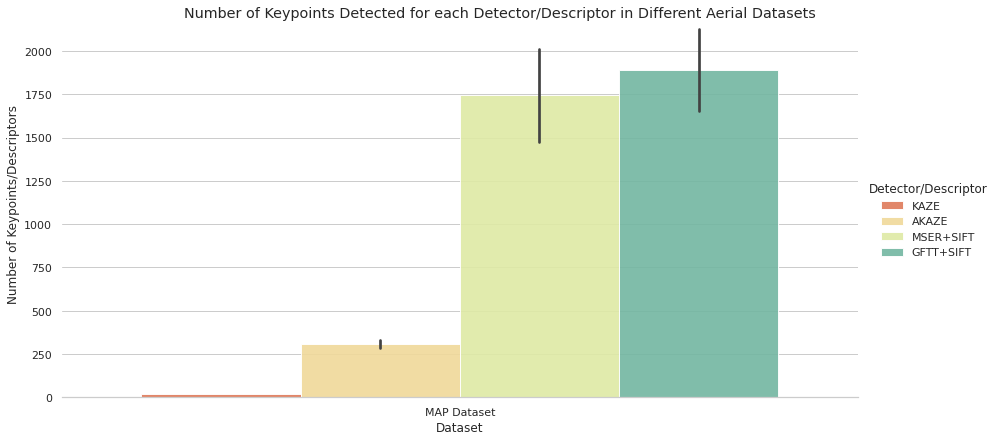

In [50]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_4, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [51]:
df_numkey_4.to_csv(f'drive/MyDrive/Num_Kypoints_4_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [52]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_kaze + num_matches_akaze +  num_matches_gftt + num_matches_mser, 'Detector/Descriptor': ['AKAZE']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) +  ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1)   }
df_match_4 = pd.DataFrame(data=d)
df_match_4['Number of Total Matches'] = df_match_4['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

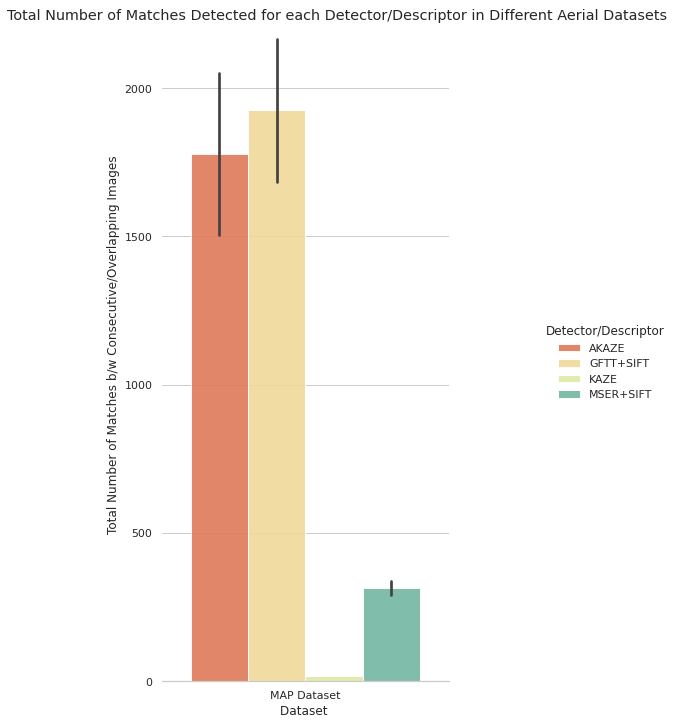

In [53]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [54]:
df_match_4['Number of Good Matches'] = num_good_matches_mser + num_good_matches_kaze + num_good_matches_akaze +  num_good_matches_gftt
df_match_4['Number of Good Matches'] = df_match_4['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

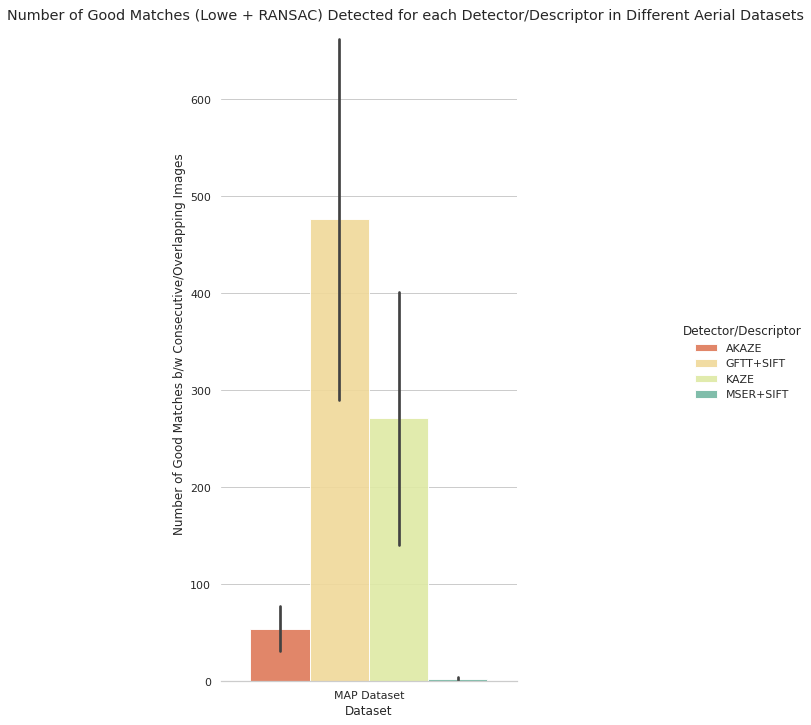

In [55]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_6.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [56]:
df_match_4['Recall Rate of Matches'] = df_match_4['Number of Good Matches']/df_match_4['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

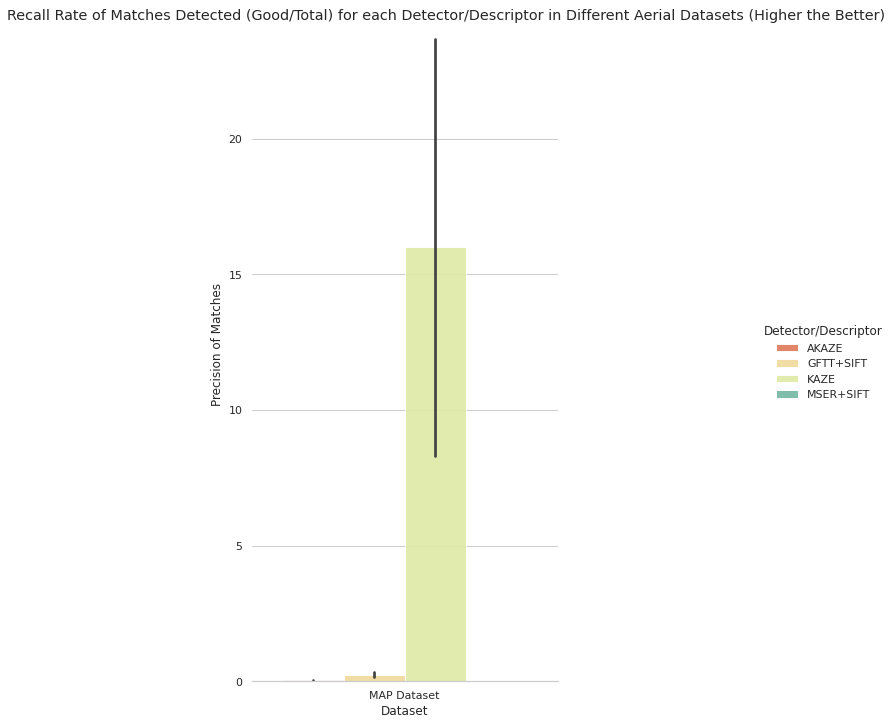

In [57]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_6.png')

1-Precision Rate for each Detector+Descriptor

In [58]:
df_match_4['1 - Precision Rate of Matches'] = (df_match_4['Number of Total Matches'] - df_match_4['Number of Good Matches'])/df_match_4['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

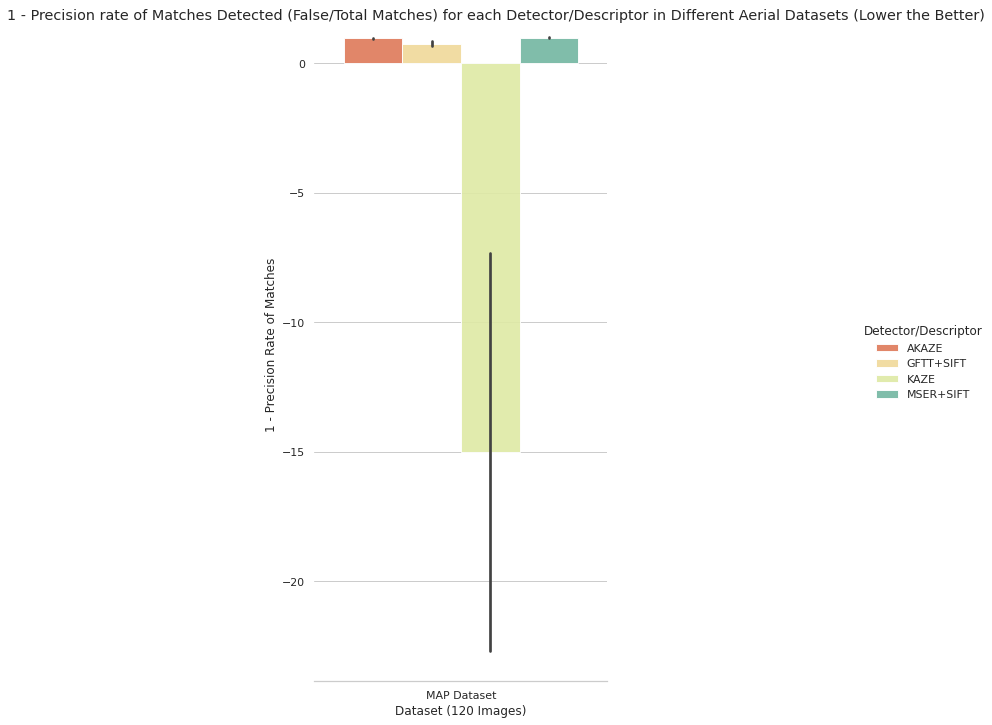

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_6.png')

F-Score for each Detector+Descriptor

In [60]:
df_match_4['F-Score'] = (2* (1 - df_match_4['1 - Precision Rate of Matches']) * df_match_4['Recall Rate of Matches'])/((1 - df_match_4['1 - Precision Rate of Matches']) + df_match_4['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

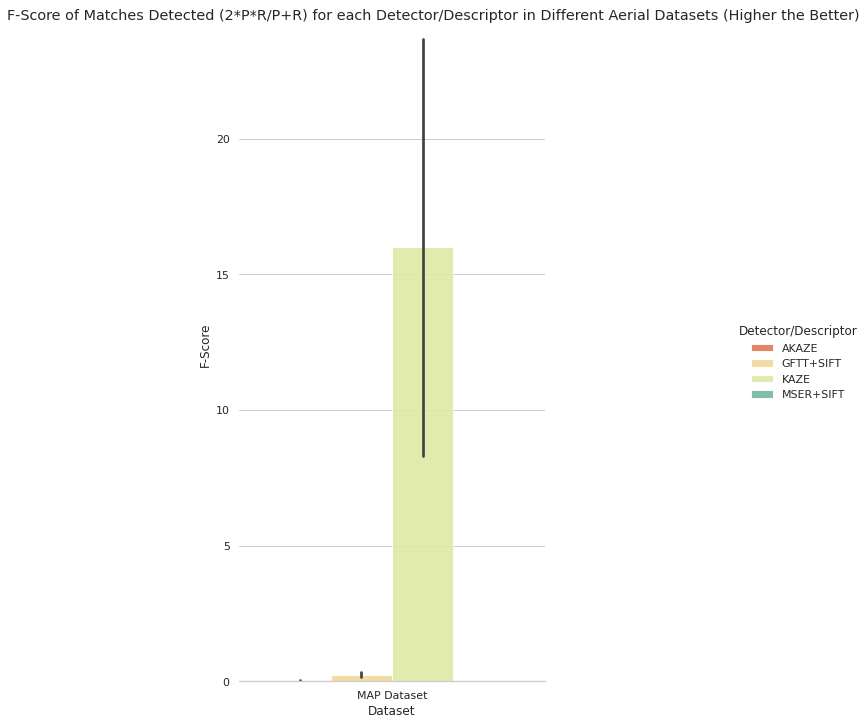

In [61]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_6.png')

In [62]:
df_match_4.to_csv('drive/MyDrive/All_metrics_4.csv')

Time for each Detector+Descriptor

In [63]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]], 'Detector/Descriptor': ['MSER+SIFT']*(1) + ['AKAZE']*(1) + ['KAZE']*(1) + ['GFTT+SIFT']*(1) }
df_time_4 = pd.DataFrame(data=d)

In [64]:
print(df_time_4)

       Dataset         Time Detector/Descriptor
0  MAP Dataset    74.663205           MSER+SIFT
1  MAP Dataset  2575.634104               AKAZE
2  MAP Dataset  2123.825640                KAZE
3  MAP Dataset   496.137449           GFTT+SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

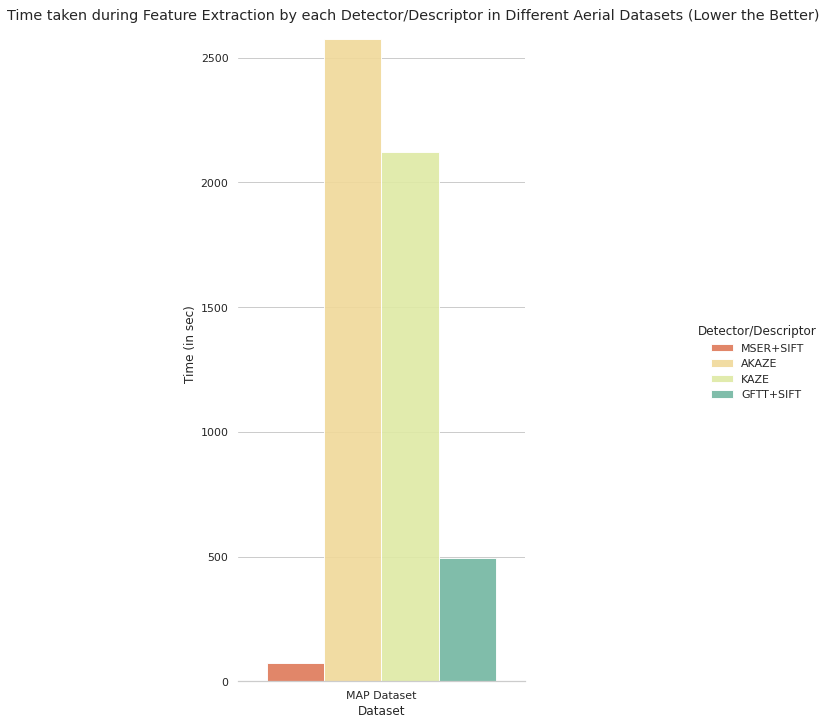

In [65]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_4, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_6.png')

In [66]:
df_time_4.to_csv('drive/MyDrive/Time_4.csv')

Stitching with CPU